### Natural Language Processing with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertModel, BertTokenizer, BertConfig, BertForSequenceClassification

2023-01-06 15:45:05.807504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 15:45:06.930449: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-06 15:45:08.637822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/lib64:/usr/lib/cuda/include:
2023-01-06 15:45:08.638224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_

In [6]:
df_train = pd.read_csv('../../data/nlp-disaster-tweets/train.csv')

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [43]:
# Preprocessing data
sentences = df_train['text'].values
sentences = [ "[CLS] " + sentence+ " [SEP]" for sentence in sentences]
labels = torch.tensor(df_train['target'].values)
# Activate BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
inputs = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors ='pt')
input_ids = inputs['input_ids']
# create attention mask
attention_masks = [[float(input_ids[i,j]>0) for j in range(input_ids.shape[1])] for i in range(input_ids.shape[0])]
attention_masks = torch.tensor(attention_masks)
attention_masks[0]


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
# Split data 
from sklearn.model_selection import train_test_split
input_ids_train, input_ids_val, labels_train, labels_val = train_test_split(input_ids,labels,random_state=2024,test_size=0.2)
attention_masks_train, attention_masks_val ,_,_ = train_test_split(attention_masks,input_ids,random_state=2024,test_size=0.2)

In [50]:
# Set device for tensors
device = torch.device('cpu')
input_ids_train=input_ids_train.to(device)
input_ids_val = input_ids_val.to(device)
labels_train = labels_train.to(device)
labels_val  = labels_val.to(device)
attention_masks_train = attention_masks_train.to(device)
attention_masks_val   = attention_masks_val.to(device)


In [51]:
# Create an iterator of our data with torch DataLoader: save memory during the training step
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 64
train_data = TensorDataset(input_ids_train,labels_train,attention_masks_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(input_ids_val,labels_val,attention_masks_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data,sampler=val_sampler, batch_size=BATCH_SIZE)



In [53]:
# Create Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [54]:
# create optimizer
optimizer = torch.optim.Adam(params=model.parameters(),lr=1.e-5,betas=(0.8,0.95))
# scheduler
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=0.5,total_iters=5)

### Training model 

In [55]:
from sklearn.metrics import accuracy_score

EPOCH = 2
train_loss_set = []
for epoch in range(EPOCH):
    model.train()
    train_loss = 0
    nb_train_steps = 0
    for step, batch in enumerate(train_dataloader):
        input_ids , labels, attention_masks  = batch
        optimizer.zero_grad()
        # forward pass
        outputs = model(input_ids,token_type_ids=None,attention_mask=attention_masks,labels=labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())
        train_loss += loss.item()
        nb_train_steps += 1
        loss.backward()
        optimizer.step()
        print('Step = {}, Loss = {}'.format(step,loss.item()))
    print(' Epoch = {} ,Train loss = {} '.format( epoch,train_loss/nb_train_steps))
    # Evaludation model
    model.eval()
    val_accuracy = 0
    nb_val_steps = 0
    for step, batch in enumerate(val_dataloader):
        input_ids , labels, attention_masks  = batch
        with torch.no_grad():
            outputs = model(input_ids,token_type_ids=None,attention_mask=attention_masks,labels=labels)
        logits = outputs['logits'].detach().cpu().numpy()
        predictions = np.argmax(logits,axis=1).flatten()
        targets = labels.cpu().numpy()
        accuracy = accuracy_score(predictions,targets)
        val_accuracy += accuracy
        nb_val_steps += 1

    print('Epoch = {}, Accuracy = {}'.format(epoch,val_accuracy/nb_val_steps))





Step = 0, Loss = 0.6673152446746826
Step = 1, Loss = 0.6680571436882019
Step = 2, Loss = 0.6691960096359253
Step = 3, Loss = 0.6488365530967712
Step = 4, Loss = 0.6687216758728027
Step = 5, Loss = 0.6672965884208679
Step = 6, Loss = 0.6108503341674805
Step = 7, Loss = 0.6715331077575684
Step = 8, Loss = 0.6485698223114014
Step = 9, Loss = 0.6486135125160217
Step = 10, Loss = 0.7201672196388245
Step = 11, Loss = 0.6299258470535278
Step = 12, Loss = 0.5927339196205139
Step = 13, Loss = 0.6686998009681702
Step = 14, Loss = 0.7047357559204102
Step = 15, Loss = 0.6616565585136414
Step = 16, Loss = 0.6671178936958313
Step = 17, Loss = 0.6897567510604858
Step = 18, Loss = 0.6584816575050354
Step = 19, Loss = 0.6483256220817566
Step = 20, Loss = 0.6811112761497498
Step = 21, Loss = 0.628757119178772
Step = 22, Loss = 0.6388530731201172
Step = 23, Loss = 0.5667803287506104
Step = 24, Loss = 0.6036950945854187
Step = 25, Loss = 0.6377149820327759
Step = 26, Loss = 0.6034371256828308
Step = 27, L

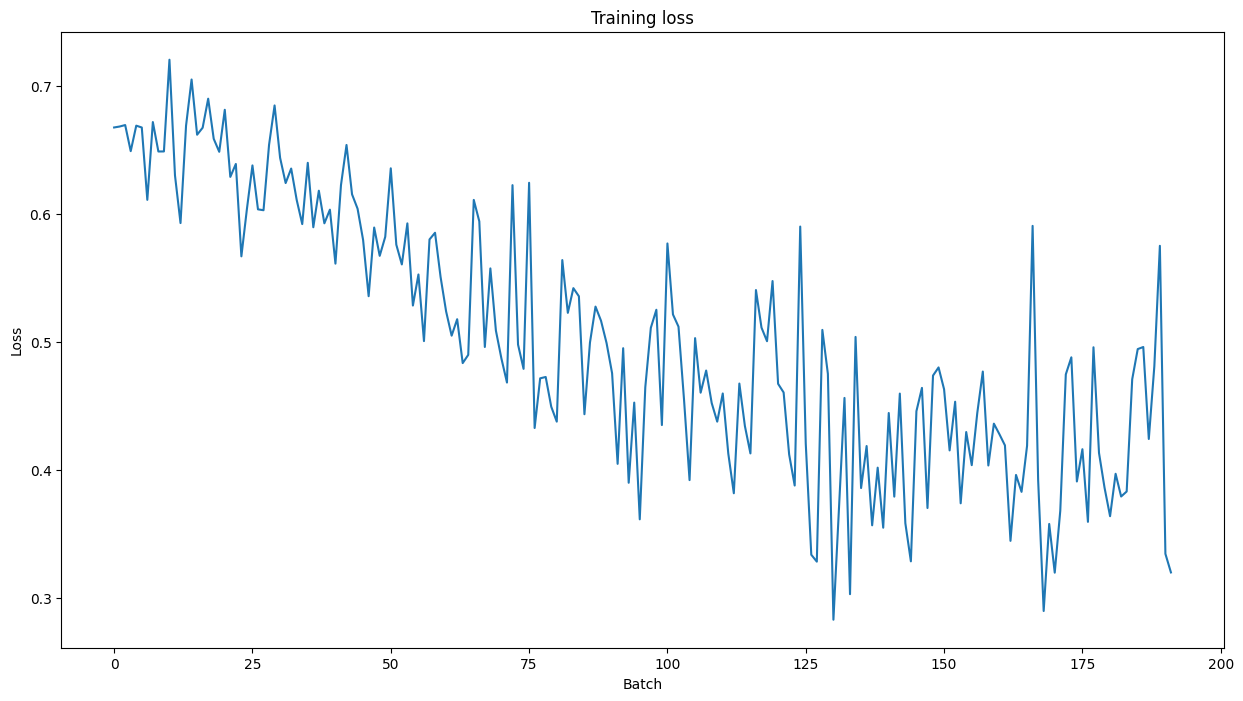

In [65]:
## Plot the training loss
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()



In [56]:
pt_save_directory = '../../fit/pt_save_pretrained_disaster_tweets'
tokenizer.save_pretrained(pt_save_directory)
model.save_pretrained(pt_save_directory)

### visualization attention 

In [62]:
pt_model = BertForSequenceClassification.from_pretrained('../../fit/pt_save_pretrained_disaster_tweets',output_attentions=True)

def get_self_attention_tokens(sentence):
    input_ids = tokenizer.encode(sentence,return_tensors='pt')
    attention = pt_model(input_ids,token_type_ids=None)[-1]
    input_id_list = input_ids[0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    return attention, tokens


In [63]:
from bertviz import head_view
sentence = df_train['text'][0]
attention, tokens = get_self_attention_tokens(sentence=sentence)
head_view(attention,tokens)

<IPython.core.display.Javascript object>

### Predictions on the test set

In [67]:
df_test  = pd.read_csv('../../data/nlp-disaster-tweets/test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [68]:
sentences_test = df_test['text'].values
sentences_test = [ "[CLS] " + sentence+ " [SEP]" for sentence in sentences_test]

# Activate BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
inputs_test = tokenizer(sentences_test, padding=True, truncation=True, max_length=128, return_tensors ='pt')
input_ids_test = inputs_test['input_ids']
# create attention mask
attention_masks_test = [[float(input_ids_test[i,j]>0) for j in range(input_ids_test.shape[1])] for i in range(input_ids_test.shape[0])]
attention_masks_test = torch.tensor(attention_masks_test)
# set device
device = torch.device('cpu')
input_ids_test=input_ids_test.to(device)
attention_masks_test = attention_masks_test.to(device)
# Dataloader
BATCH_SIZE = 64
test_data = TensorDataset(input_ids_test,attention_masks_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,sampler=test_sampler, batch_size=BATCH_SIZE)

In [69]:
Total_predictions=[]
model.eval()
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids , attention_masks  = batch
    with torch.no_grad():
        outputs = model(input_ids,token_type_ids=None,attention_mask=attention_masks)
    logits = outputs['logits'].detach().cpu().numpy()
    predictions = np.argmax(logits,axis=1).flatten()
    Total_predictions.append(predictions)
Total_predictions

[array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
 array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1

In [73]:
df_test['labels'] = np.hstack(Total_predictions)
df_test.head(20)
df_test.to_csv('../../results/Disaster_tweets_predictions.csv')